In [1]:
# Jason Qin
# 04/20/21

# Analyzing Generated Data

In [28]:
import sys
import numpy as np
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import torch

from scipy.spatial.distance import cdist, hamming
import scipy.stats

from tape.datasets import FastaDataset, pad_sequences
from tape.tokenizers import TAPETokenizer

### Finding Perfect Predictions in Generated Data

In [3]:
results_data_dir = '/group/ag_cmb/scratch/jqin/projects/tape/results/tcr_transformer_21-04-08-22-42-38_231772/'
data_file = results_data_dir + 'generate_results_3_220421_043126.txt'
data = pandas.read_csv(data_file, sep='\t')

In [4]:
# clean and organize data
column_names = ['TCR', 'antigen', 'prediction']
for col in column_names:
    # remove all non-numeric parts of data
    data[col] = data[col].str.replace(r'.*\[', '')
    data[col] = data[col].str.replace(r'\].*', '')
    data[col] = data[col].str.replace(r'        ', ',')
    data[col] = data[col].str.strip()
    
    # convert comma-separated string of ints to list of ints
    data[col] = [np.array([int(float(y.strip('.'))) for y in x]) for x in data[col].str.split(',')]

<ipython-input-4-48522cd36268>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  data[col] = data[col].str.replace(r'.*\[', '')
<ipython-input-4-48522cd36268>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  data[col] = data[col].str.replace(r'\].*', '')


In [5]:
antigens = data['antigen']
predictions = data['prediction']

In [6]:
# reduce length of predictions to be closest to each antigen
# this lets us find the closest match between the targets and the
# generated predictions
truncated_predictions = []
for antigen, pred in zip(antigens, predictions):
    stop_idx = np.where(antigen == 3)[0][0]
    if antigen.shape[0] < pred.shape[0]:
        pred[stop_idx] = 3
        pred = pred[0:(stop_idx+1)]
    truncated_predictions += [pred]

In [7]:
# compare truncated predictions to the known targets
truncated_differences = []
for antigen, pred in zip(antigens, truncated_predictions):
    antigen = np.expand_dims(antigen, 0)
    pred = np.expand_dims(pred, 0)
    truncated_differences += [cdist(antigen, pred, metric='hamming').squeeze()]

In [8]:
# truncated predictions and Hamming distance scores of truncated predictions
# to data frame
data['truncated_prediction'] = truncated_predictions
data['truncated_difference'] = truncated_differences

In [9]:
# find all sequences that were perfectly predicted
perf_preds = data[data['truncated_difference'] == 0]['truncated_prediction']

In [10]:
print('Number of total sequences with predictions: {}'.format(data.shape[0]))
print('Number of perfect predictions (after truncation): {}'.format(len(perf_preds)))

Number of total sequences with predictions: 3936
Number of perfect predictions (after truncation): 761


In [12]:
# how many of the unique sequences are there in those that were 
# perfectly predicted?
unique_perf_preds = [list(y) for y in set(tuple(x) for x in perf_preds)]

In [13]:
print('Among perfect predictions, number of unique sequences: {}'.format(len(unique_perf_preds)))

Among perfect predictions, number of unique sequences: 39


In [14]:
# how many times does each of the N unique sequences get generated?
unique_pred_counts = []
for pred in unique_perf_preds:
    pred_match = [list(x) == pred for x in perf_preds]
    unique_pred_counts += [sum(pred_match)]

[2, 3, 1, 1, 1, 14, 46, 4, 3, 1, 4, 1, 2, 3, 3, 2, 300, 1, 1, 1, 4, 2, 49, 3, 6, 4, 1, 3, 2, 3, 17, 1, 1, 1, 1, 4, 248, 10, 7]


(array([35.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([  1. ,  30.9,  60.8,  90.7, 120.6, 150.5, 180.4, 210.3, 240.2,
        270.1, 300. ]),
 <BarContainer object of 10 artists>)

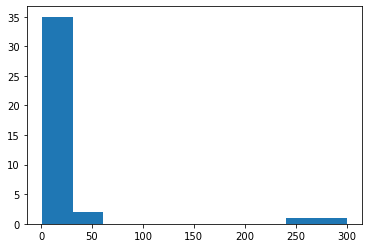

In [15]:
print(unique_pred_counts)
plt.hist(unique_pred_counts)

### Compare Training Data to Validation Data

In [16]:
# relevant data files
data_dir = '/group/ag_cmb/scratch/jqin/projects/tape/data/tcr/'
cdr3_train_file = data_dir + '/cdr3_train.fasta'
antigen_train_file = data_dir + '/antigen_train.fasta'
cdr3_valid_file = data_dir + '/cdr3_valid.fasta'
antigen_valid_file = data_dir + '/antigen_valid.fasta'

# set up tokenizer
tokenizer = TAPETokenizer(vocab='iupac')

# load relevant data
antigen_train_data_uncleaned = FastaDataset(antigen_train_file, in_memory=True)

In [17]:
# organize data
antigen_train_data = [list(tokenizer.encode(x['primary'])) for x in antigen_train_data_uncleaned]

In [18]:
# find number of times each unique perfect (truncated) prediction 
# can be found in training data
unique_pred_counts_in_train = []
for pred in unique_perf_preds:
    pred_match = [list(x) == pred for x in antigen_train_data]
    unique_pred_counts_in_train += [sum(pred_match)]

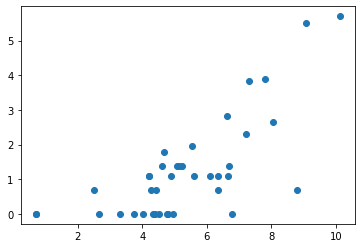

In [19]:
plt.scatter(np.log(unique_pred_counts_in_train), np.log(unique_pred_counts))

In [20]:
# what is correlation between Hamming distance and number of same
# antigens seen in training data?
all_pred_counts_in_train = []
for pred in truncated_predictions:
    pred_match = [list(x) == list(pred) for x in antigen_train_data]
    all_pred_counts_in_train += [sum(pred_match)]

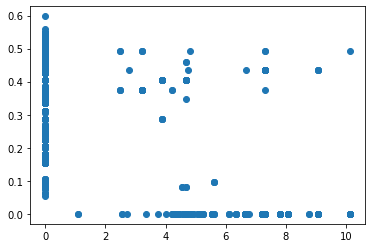

In [21]:
plt.scatter(np.log(np.array(all_pred_counts_in_train)+1), np.log(np.array(truncated_differences)+1))

### Analyze Beam Search

How highly scored are the most accurate predictions?

In [24]:
generation_results_file = results_data_dir + 'generate_full_results_3_220421_043126.pkl'
generation_results = pkl.load(open(generation_results_file, 'rb'))

In [25]:
generation_results.keys()

dict_keys(['scores', 'inputs', 'targets', 'all_outputs', 'all_output_probs', 'best_outputs'])

In [26]:
antigen_targets = generation_results['targets']
antigen_predictions = generation_results['all_outputs']
antigen_prediction_scores = generation_results['all_output_probs']

pred_len = len(antigen_predictions[0][0])

/group/ag_cmb/scratch/jqin/miniconda3/envs/tape/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

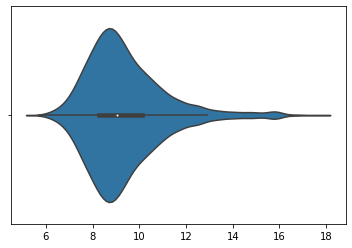

In [35]:
sns.violinplot(np.array(antigen_prediction_scores[3].cpu()))

In [39]:
antigen_pred_dists = []

for target, antigen_preds in zip(antigen_targets, antigen_predictions):
    target = target.cpu().type(torch.FloatTensor)
    target_len = target.shape[1]
    target = torch.nn.functional.pad(target, (0, pred_len-target_len))
    # dists = cdist(target, antigen_preds.cpu(), metric='hamming')
    antigen_preds = antigen_preds.cpu().type(torch.FloatTensor)
    dists = torch.cdist(target, antigen_preds, p=0).squeeze()
    antigen_pred_dists += [dists]

/group/ag_cmb/scratch/jqin/miniconda3/envs/tape/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

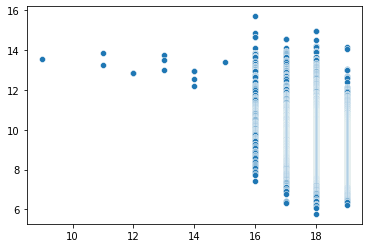

In [51]:
i = 4
sns.scatterplot(antigen_pred_dists[i], np.array(antigen_prediction_scores[i].cpu()))

In [56]:
score_dist_corr = []

for pred_dists, pred_scores in zip(antigen_pred_dists, antigen_prediction_scores):
    corr = np.corrcoef(pred_dists, np.array(pred_scores.cpu()))
    score_dist_corr += [corr[0, 1]]

/group/ag_cmb/scratch/jqin/miniconda3/envs/tape/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

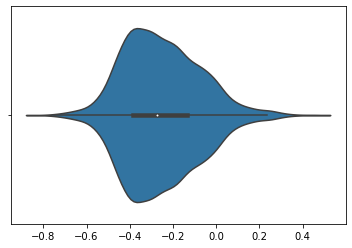

In [59]:
sns.violinplot(score_dist_corr)

In [ ]:
sns.scatterplot(antigen_pred_dists[i], )

In [46]:
scipy.stats.describe(min_dists)

DescribeResult(nobs=3936, minmax=(2.0, 18.0), mean=12.766514, variance=7.3220906, skewness=-0.9243189692497253, kurtosis=0.9219455424074217)

In [42]:
generation_results['best_outputs'][0]

tensor([ 2., 17., 15., 22.,  5., 19., 25., 13., 23., 19., 16.,  9., 25.,  9.,
        15.,  5., 17., 21., 23.,  3.], device='cuda:0')

In [22]:
data

,score,TCR,antigen,prediction,truncated_prediction,truncated_difference
0,15.0,"[2, 7, 5, 23, 22, 11, 21, 19, 11, 22, 22, 28, ...","[2, 17, 15, 25, 19, 16, 25, 5, 23, 25, 3]","[2, 17, 15, 22, 5, 19, 25, 13, 23, 19, 3, 9, 2...","[2, 17, 15, 22, 5, 19, 25, 13, 23, 19, 3]",0.45454545454545453
1,10.0,"[2, 7, 5, 22, 22, 15, 11, 10, 23, 8, 23, 20, 2...","[2, 11, 13, 15, 11, 10, 25, 10, 23, 15, 3]","[2, 11, 13, 15, 11, 10, 25, 10, 23, 15, 3, 11,...","[2, 11, 13, 15, 11, 10, 25, 10, 23, 15, 3]",0.0
2,10.0,"[2, 7, 5, 28, 11, 23, 17, 5, 11, 11, 23, 22, 2...","[2, 11, 13, 15, 11, 10, 25, 10, 23, 15, 3]","[2, 11, 13, 15, 11, 10, 25, 10, 23, 15, 3, 23,...","[2, 11, 13, 15, 11, 10, 25, 10, 23, 15, 3]",0.0
3,10.0,"[2, 7, 5, 22, 22, 13, 21, 22, 23, 28, 9, 20, 2...","[2, 11, 13, 15, 11, 10, 25, 10, 23, 15, 3]","[2, 11, 13, 15, 11, 10, 25, 10, 23, 15, 3, 23,...","[2, 11, 13, 15, 11, 10, 25, 10, 23, 15, 3]",0.0
4,10.0,"[2, 7, 22, 5, 21, 8, 15, 5, 11, 17, 9, 20, 10,...","[2, 14, 15, 11, 11, 5, 15, 20, 5, 14, 3]","[2, 14, 15, 11, 11, 5, 15, 20, 5, 14, 3, 26, 2...","[2, 14, 15, 11, 11, 5, 15, 20, 5, 14, 3]",0.0
...,...,...,...,...,...,...
3931,9.0,"[2, 7, 5, 28, 21, 23, 22, 5, 22, 17, 23, 8, 14...","[2, 5, 25, 10, 8, 21, 14, 22, 8, 5, 14, 3]","[2, 5, 25, 10, 8, 21, 14, 22, 8, 5, 14, 3, 21,...","[2, 5, 25, 10, 8, 21, 14, 22, 8, 5, 14, 3]",0.0
3932,15.0,"[2, 7, 15, 25, 11, 9, 5, 16, 17, 22, 17, 22, 1...","[2, 5, 25, 10, 8, 21, 14, 22, 8, 5, 14, 3]","[2, 11, 16, 10, 8, 16, 15, 22, 20, 5, 15, 3, 2...","[2, 11, 16, 10, 8, 16, 15, 22, 20, 5, 15, 3]",0.5
3933,15.0,"[2, 7, 5, 22, 22, 21, 8, 26, 11, 8, 28, 9, 20,...","[2, 21, 5, 15, 9, 28, 14, 17, 15, 3]","[2, 21, 5, 19, 10, 14, 20, 17, 15, 3, 20, 15, ...","[2, 21, 5, 19, 10, 14, 20, 17, 15, 3]",0.4
3934,12.0,"[2, 7, 5, 22, 22, 28, 26, 19, 8, 28, 11, 28, 2...","[2, 14, 15, 11, 11, 5, 15, 20, 5, 14, 3]","[2, 14, 15, 11, 11, 5, 15, 20, 21, 5, 3, 5, 26...","[2, 14, 15, 11, 11, 5, 15, 20, 21, 5, 3]",0.18181818181818182
